In [118]:
import pandas as pd
# datasets have no missing values
df = pd.read_csv("resale-flat-prices-based-on-registration-date-from-jan-2017-onwards.csv")
# df = pd.read_csv("resale-flat-prices-based-on-registration-date-from-jan-2015-to-dec-2016.csv")

# datasets below have 10 columns instead of 11, doesn't have 'remaining_lease'
# df = pd.read_csv("resale-flat-prices-based-on-registration-date-from-mar-2012-to-dec-2014.csv")
# df = pd.read_csv("resale-flat-prices-based-on-approval-date-2000-feb-2012.csv")
# df = pd.read_csv("resale-flat-prices-based-on-approval-date-1990-1999.csv")

In [ ]:
df['month'] = pd.to_datetime(df['month'])
df['Year'] = df['month'].apply(lambda x: x.year)
df['Month'] = df['month'].apply(lambda x: x.month)

df = df[df['Year'] == 2019]
df.sample()



df['remaining_lease'] = 99 - (2019 - df['lease_commence_date'])
df['house_age'] = df['Year'] - df['lease_commence_date']
df['flat_type_model'] = df['flat_type']+' '+df['flat_model']
df = df.drop(columns = ['flat_model','flat_type'])
df.head()
df = df[df['Year'] == 2019]
df = df.drop(columns = ['Year','month','block','street_name'])

In [ ]:
df = df.sample(frac=1).reset_index(drop=True)
# shuffled the dataframe to help split train and test datasets later
# https://stackoverflow.com/questions/29576430/shuffle-dataframe-rows

In [ ]:
df.head()

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import warnings
from scipy.stats import norm
from scipy import stats
from scipy.stats import skew
import lightgbm as lgb
# install lightgbm that is compatible for win64
from scipy.stats.stats import pearsonr
from collections import Counter
from sklearn.linear_model import LinearRegression,LassoCV, Ridge, LassoLarsCV,ElasticNetCV
from sklearn.model_selection import GridSearchCV, cross_val_score, learning_curve
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, Normalizer, RobustScaler
warnings.filterwarnings('ignore')
sns.set(style='white', context='notebook', palette='deep')
%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline
# import xgboost as xgb
# import libxgboost as lxgb
# able to install libxgboost (compatible for win64) but unable to import

In [ ]:
# multivariate analysis
# checking categorical data
df.select_dtypes(include=['object']).columns

In [ ]:
#Checking numerical data
df.select_dtypes(include=['int64','float64']).columns

In [ ]:
# Total number of features
cat = len(df.select_dtypes(include=['object']).columns)
num = len(df.select_dtypes(include=['int64','float64']).columns)
print('Total Features: ', cat, 'categorical', '+', num, 'numerical', '=', cat+num, 'features')

In [ ]:
# Check if there are any missing values in the dataset
target = df.resale_price.values
all_data = df.reset_index(drop=True)
all_data.drop(['resale_price'], axis=1, inplace=True)
print("Train data size is : {}".format(df.shape))
print("New dataset size is : {}".format(all_data.shape))
all_data.isnull().sum()
# no missing data

# Find Missing Ratio of Dataset
# all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
# all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
# missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
# missing_data
# skip because already know there are no missing values

In [ ]:
df['resale_price']

In [97]:
# converting categorical variables into numerical

# get_dummies method
# all_data = pd.get_dummies(all_data)
# get_dummies convert categorical variable into dummy/indicator variables e.g. flat_model_Simplified with 0s and 1s
# https://www.w3resource.com/pandas/get_dummies.php
# lightgbm gives the best rmse when using get_dummies method

# label encoder method
from sklearn import preprocessing
for column in all_data.columns:
    if df[column].dtype == type(object):
        le = preprocessing.LabelEncoder()
        all_data[column] = le.fit_transform(all_data[column])
# supposedly used for labels y and not x
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html
# gradient boost gives the best rmse when using label encoder
# overall best rmse when comparing the two methods as well

print(all_data.shape)
# all_data.head()
# (75473, 3712)
# (75473, 10)

(22186, 8)


In [110]:
# Check if there are any missing values in the dataset
target = df.resale_price.values
all_data = df.reset_index(drop=True)
all_data.drop(['resale_price'], axis=1, inplace=True)
print("Train data size is : {}".format(df.shape))
print("New dataset size is : {}".format(all_data.shape))
all_data.isnull().sum()
# no missing data

# Find Missing Ratio of Dataset
# all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
# all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
# missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
# missing_data
# skip because already know there are no missing values

Train data size is : (22186, 9)
New dataset size is : (22186, 8)


town                   0
storey_range           0
floor_area_sqm         0
lease_commence_date    0
remaining_lease        0
Month                  0
house_age              0
flat_type_model        0
dtype: int64

In [ ]:
train = all_data[:5000]
test = all_data[5000:10000]
y_train = target[:5000]
y_test = target[5000:10000]

In [111]:
x = df
y = df['flat_type_model']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2,
random_state = 1)
train = x_train
test = x_test

In [112]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split

In [113]:
# Train set evaluation metrics with cross-validation
n_folds = 5

def MAE_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    MAE = -cross_val_score(model, train.values, y_train, scoring='neg_mean_absolute_error', cv = kf)
    return MAE
    
def MSE_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    MSE = -cross_val_score(model, train.values, y_train, scoring='neg_mean_squared_error', cv = kf)
    return MSE

def RMSE_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

def r2_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    r2 = cross_val_score(model, train.values, y_train, scoring='r2', cv = kf)
    return r2

# full list of scorers
# from sklearn.metrics import SCORERS
# sorted(SCORERS.keys())
# no adjusted r2

In [114]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

In [115]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)  
    
averaged_models = AveragingModels(models = (ENet, GBoost, KRR, lasso))

In [116]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, clf in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(clf)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

stacked_averaged_models = StackingAveragedModels(base_models = (lasso, ENet, KRR),
                                                 meta_model = GBoost)

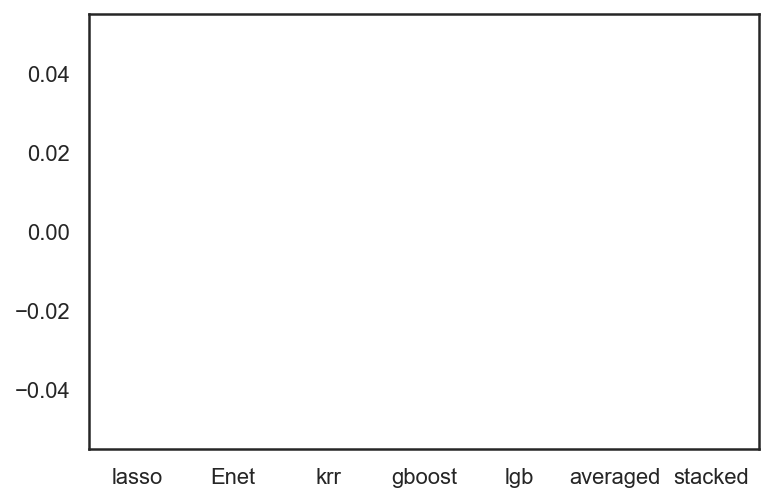

In [117]:
# Mean Absolute Error (MAE) Evaluation
models = [lasso, ENet, KRR, GBoost, model_lgb, averaged_models, stacked_averaged_models]
MAE_results = []
for model in models:
    MAE_results.append(MAE_cv(model))

names = ['lasso', 'Enet', 'krr', 'gboost', 'lgb', 'averaged', 'stacked']
plt.boxplot(MAE_results, labels=names, showmeans=True)
plt.show()

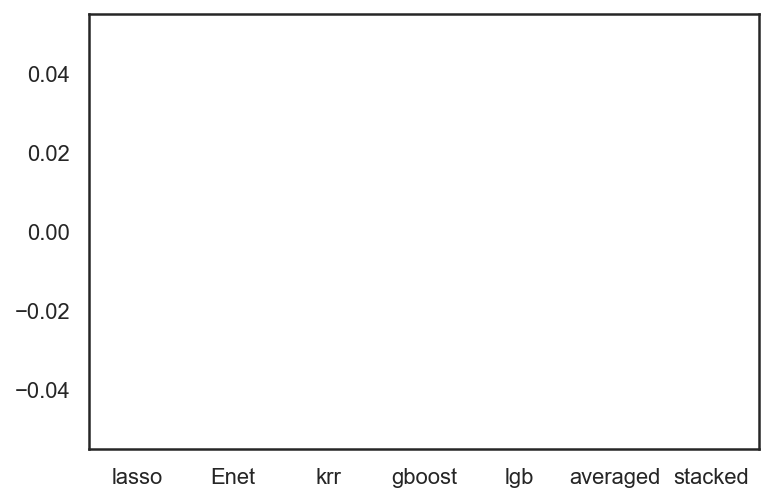

In [107]:
# Mean Squared Error (MSE) Evaluation
MSE_results = []
for model in models:
    MSE_results.append(MSE_cv(model))
plt.boxplot(MSE_results, labels=names, showmeans=True)
plt.show()

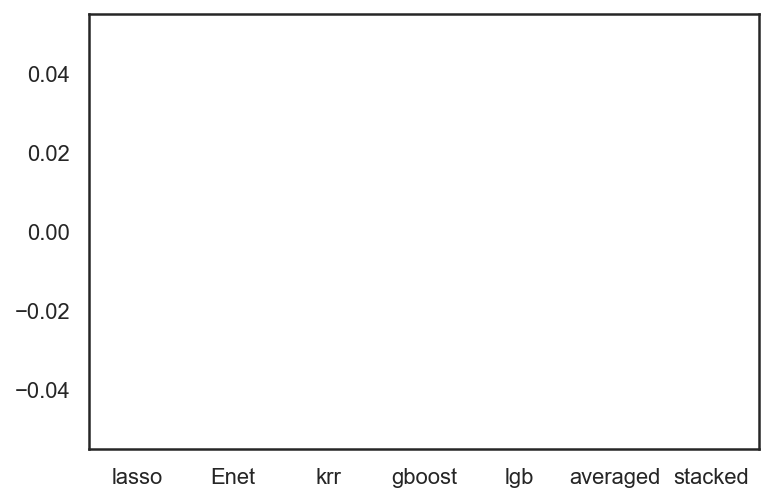

In [108]:
# Root Mean Square Error (RMSE) Evaluation
RMSE_results = []
for model in models:
    RMSE_results.append(RMSE_cv(model))
plt.boxplot(RMSE_results, labels=names, showmeans=True)
plt.show()

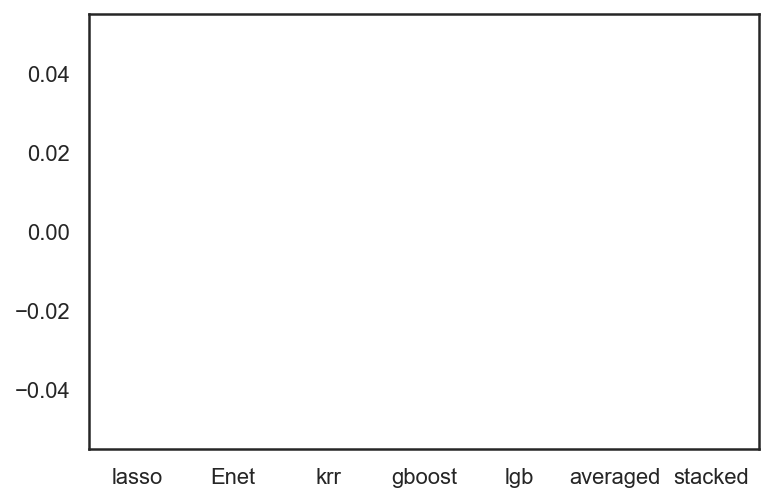

In [109]:
# R2 Evaluation
r2_results = []
for model in models:
    r2_results.append(r2_cv(model))
plt.boxplot(r2_results, labels=names, showmeans=True)
plt.show()

In [32]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

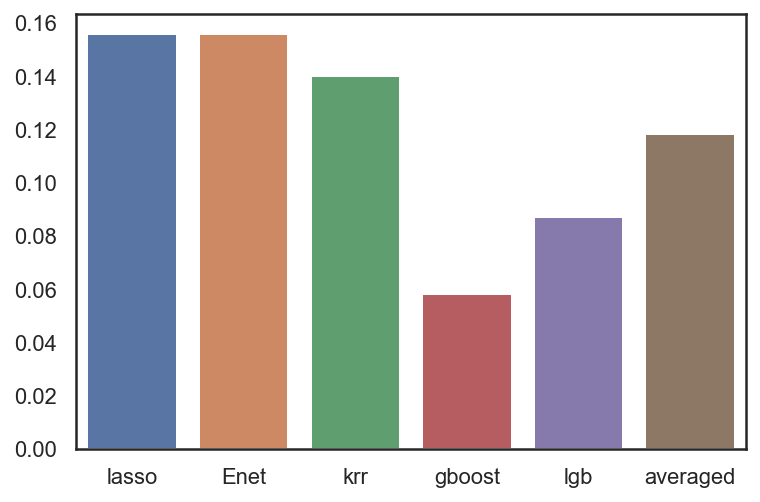

In [33]:
# Mean Absolute Error (MAE) Evaluation
models = [lasso, ENet, KRR, GBoost, model_lgb, averaged_models]
# currently unable to do for stacked_averaged_models
MAE_results = []
for model in models:
    model.fit(train, y_train)
    MAE_results.append(mean_absolute_error(y_test, model.predict(test.values)))
names = ['lasso', 'Enet', 'krr', 'gboost', 'lgb', 'averaged']
sns.barplot(names, MAE_results)

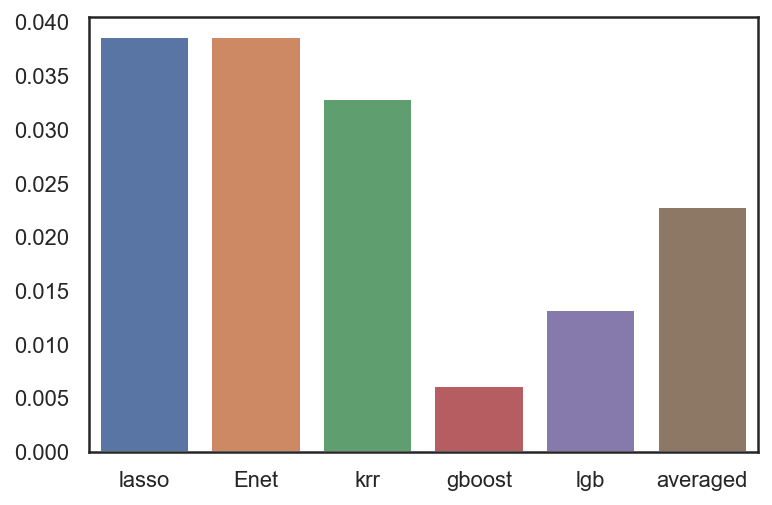

In [34]:
# Mean Squared Error (MSE) Evaluation
MSE_results = []
for model in models:
    MSE_results.append(mean_squared_error(y_test, model.predict(test.values)))
sns.barplot(names, MSE_results)

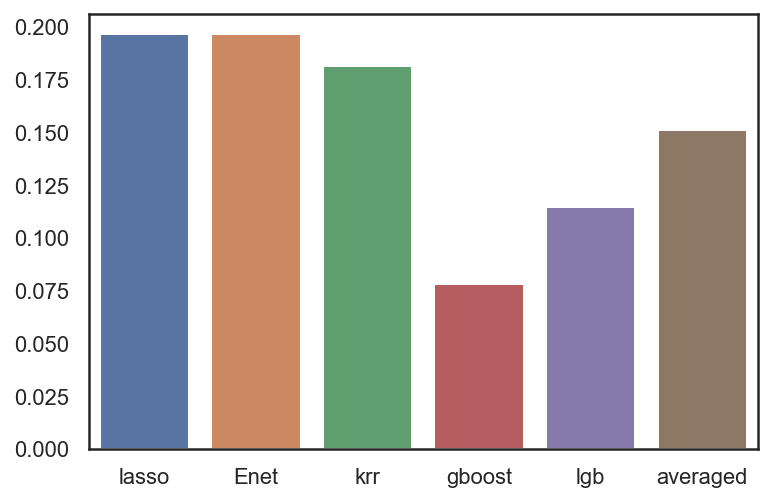

In [35]:
# Root Mean Squared Error (RMSE) Evaluation
RMSE_results = []
for model in models:
    RMSE_results.append(np.sqrt(mean_squared_error(y_test, model.predict(test.values))))
sns.barplot(names, RMSE_results)

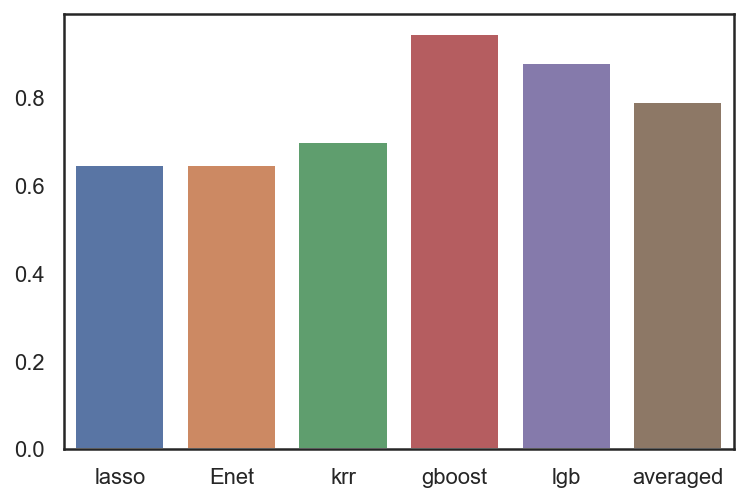

In [36]:
# R2 Evaluation
r2_results = []
adjusted_r2_results = []
p = df.shape[1]
n = y_test.shape[0]
for model in models:
    r2 = r2_score(y_test, model.predict(test.values))
    r2_results.append(r2)
    adjusted_r2_results.append(1-(1-r2)*((n-1)/(n-p-1)))
sns.barplot(names, r2_results)

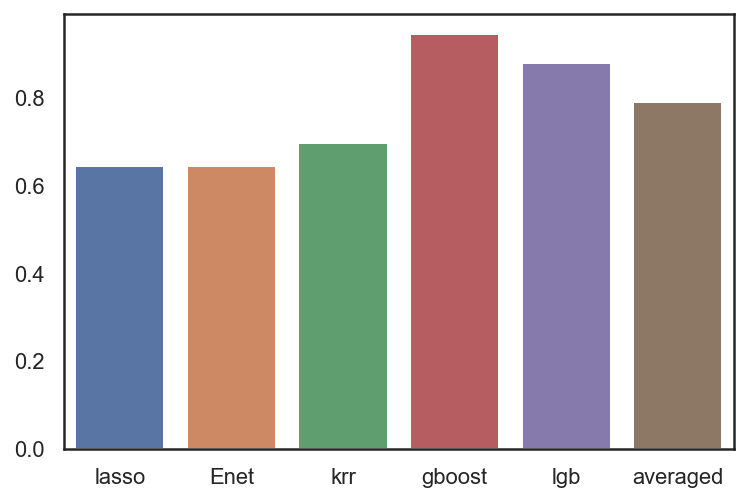

In [37]:
# Adjusted R2 Evaluation
# https://en.wikipedia.org/wiki/Coefficient_of_determination#Adjusted_R2
# p is the total number of explanatory variables in the model (not including the constant term), and n is the sample size.

sns.barplot(names, adjusted_r2_results)